# Comparison of Positioning Algorithms

> This Notebook is inspired by the [Solar Position](https://assessingsolar.org/notebooks/solar_position.html) article by _The Assessing Solar Community (2022)_.


Following we demonstrate the calculation of solar position angles used to calculate the photovoltaic power output in PVGIS.

<div class="grid cards" markdown>

- __Comparison of Positioning Algorithms__

    - NOAA solar geometry equations in PVGIS 6
    - NREL's SPA and other algoruthms via `pvlib`

- __Difference Plots__

    - Difference of solar zenith, azimuth for 2010 over a location in the ESTI Lab, JRC, Ispra
    - Difference of solar incidence angle for a solar surface facing south and tilted at 45°

- __Solar Analemma__

   A solar analemma plot for 2010 over the same location in ESTI Lab, JRC, Ispra

</div>

## Programmatic preamble

In [1]:
from zoneinfo import ZoneInfo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pvgisprototype.api.position.overview import model_solar_position_overview_series
from pvgisprototype import Longitude
from pvgisprototype import Latitude
from pvgisprototype import SurfaceOrientation
from pvgisprototype import SurfaceTilt
from pvgisprototype.constants import DEGREES
from pvgisprototype.api.position.models import SolarPositionModel
from pvgisprototype.api.position.models import SolarIncidenceModel

## Data preparation

First, we define some basic parameters for a location, in which case it is a solar panel located behind the ESTI Lab, in the JRC, European Commission.

In [2]:
latitude = Latitude(value=45.812, unit=DEGREES)
longitude = Longitude(value=8.628, unit=DEGREES)
elevation = 214
timezone = ZoneInfo("UTC")
start_time = '2010-01-01 00:10:00'
end_time = '2010-12-31 23:59:00'
frequency = 'h'
timestamps = pd.date_range(start_time, end_time, freq=frequency, tz=timezone)
surface_orientation = SurfaceOrientation(value=180, unit=DEGREES)
surface_tilt = SurfaceTilt(value=45, unit=DEGREES)

One important note : we set the start time at +10' fom the beginning of the first hour of the first day! This is to match the timestamps generated by PVGIS v5.2 that acount for the real time of acquisitin of SARAH3 data and obviously for the specific location.

In [3]:
from pandas import read_csv
from pandas import to_datetime
pvgis_52_orientation_180_tilt_45_2010 = read_csv('t.csv')

# attach timezone to DatetimeIndex
pvgis_52_orientation_180_tilt_45_2010.index = to_datetime(pvgis_52_orientation_180_tilt_45_2010['Timestamp'])
pvgis_52 = pvgis_52_orientation_180_tilt_45_2010.tz_localize(timezone)

## Solar position parameters

We then use the `model_solar_position_overview_series()` function to calculate a series of solar position parameters.

In [4]:
(
    declination,
    hour_angle,
    zenith,
    altitude,
    azimuth,
    orientation,
    tilt,
    incidence,
    sun_horizon_position_series,
    surface_in_shade_series,
    solar_event_type_series,
    solar_event_time_series,
) = model_solar_position_overview_series(
    longitude=longitude,
    latitude=latitude,
    timestamps=timestamps,
    timezone=timezone,
    surface_orientation=surface_orientation,
    surface_tilt=surface_tilt,
    solar_position_model=SolarPositionModel.noaa,
    apply_atmospheric_refraction=False,
    solar_incidence_model=SolarIncidenceModel.iqbal,
    zero_negative_solar_incidence_angle=False,
)

And as simple as that we can get an overview of the positing parameters for the specific period over the locaton of our interest.

With minimal effort, we can calculate the same parameters yet using another algorithm, for example the equations used by Hofierka (2002) who bases upon the work by Jenco (1992).

In [5]:
(
    declination_jenco,
    hour_angle_jenco,
    zenith_jenco,
    altitude_jenco,
    azimuth_jenco,
    orientation_jenco,
    tilt_jenco,
    incidence_jenco,
    sun_horizon_position_jenco,
    surface_in_shade_jenco,
    solar_event_type_jenco,
    solar_event_time_jenco,
) = model_solar_position_overview_series(
    longitude=longitude,
    latitude=latitude,
    timestamps=timestamps,
    timezone=timezone,
    surface_orientation=surface_orientation,
    surface_tilt=surface_tilt,
    solar_position_model=SolarPositionModel.jenco,
    apply_atmospheric_refraction=False,
    solar_incidence_model=SolarIncidenceModel.iqbal,
    zero_negative_solar_incidence_angle=False,
)

We do practically the same using `pvlib` to get position parameters from other implementations.

In [6]:
# Prepare pvlib data
import pvlib
from pvlib.location import Location
site = Location(latitude.degrees, longitude.degrees, 'UTC', elevation, 'ESTI Ispra') # latitude, longitude, time_zone, altitude, name

In [7]:
# Definition of a time range of simulation
# times = pd.date_range(start_time, end_time, freq=frequency, tz=site.tz)
solpos_nrel = pvlib.solarposition.get_solarposition(timestamps, site.latitude, site.longitude, site.altitude, method='nrel_numpy')
solpos_pyephem = pvlib.solarposition.get_solarposition(timestamps, site.latitude, site.longitude, site.altitude, method='pyephem')
solpos_ephemeris = pvlib.solarposition.get_solarposition(timestamps, site.latitude, site.longitude, site.altitude, method='ephemeris')

In [8]:
solar_incidence_series_pvlib_nrel = pvlib.irradiance.aoi(
    surface_tilt=surface_tilt.degrees,
    surface_azimuth=surface_orientation.degrees,
    solar_zenith=solpos_nrel['zenith'],
    solar_azimuth=solpos_nrel['azimuth'],
)


In [9]:
solar_incidence_series_pvlib_pyephem = pvlib.irradiance.aoi(
    surface_tilt=surface_tilt.degrees,
    surface_azimuth=surface_orientation.degrees,
    solar_zenith=solpos_pyephem['zenith'],
    solar_azimuth=solpos_pyephem['azimuth'],
)

In [10]:
solar_incidence_series_pvlib_ephemeris = pvlib.irradiance.aoi(
    surface_tilt=surface_tilt.degrees,
    surface_azimuth=surface_orientation.degrees,
    solar_zenith=solpos_ephemeris['zenith'],
    solar_azimuth=solpos_ephemeris['azimuth'],
)

## Visualisation

We can generate a Pandas `DataFrame` for easy visualization

In [11]:
data = pd.DataFrame({
    'Datetime': timestamps, 
    'Solar Declination': declination.degrees,
    'Solar Hour Angle': hour_angle.degrees,
    'Solar Zenith': zenith.degrees,
    'Solar Altitude': altitude.degrees,
    'Solar Azimuth': azimuth.degrees,
    'Surface orientation': surface_orientation.degrees,
    'Solar Incidence': incidence.degrees,
})
data.set_index('Datetime', inplace=True)

In [12]:
data_jenco = pd.DataFrame({
    'Datetime': timestamps, 
    'Solar Declination': declination_jenco.degrees,
    'Solar Altitude': altitude_jenco.degrees,
    'Solar Azimuth': azimuth_jenco.degrees,
    'Surface orientation': surface_orientation.degrees,
    'Solar Incidence': incidence_jenco.degrees,
})
data_jenco.set_index('Datetime', inplace=True)

### Solar zenith, azimuth, incidence

We can plot the solar zenith, azimuth and incidence angles for 2010.

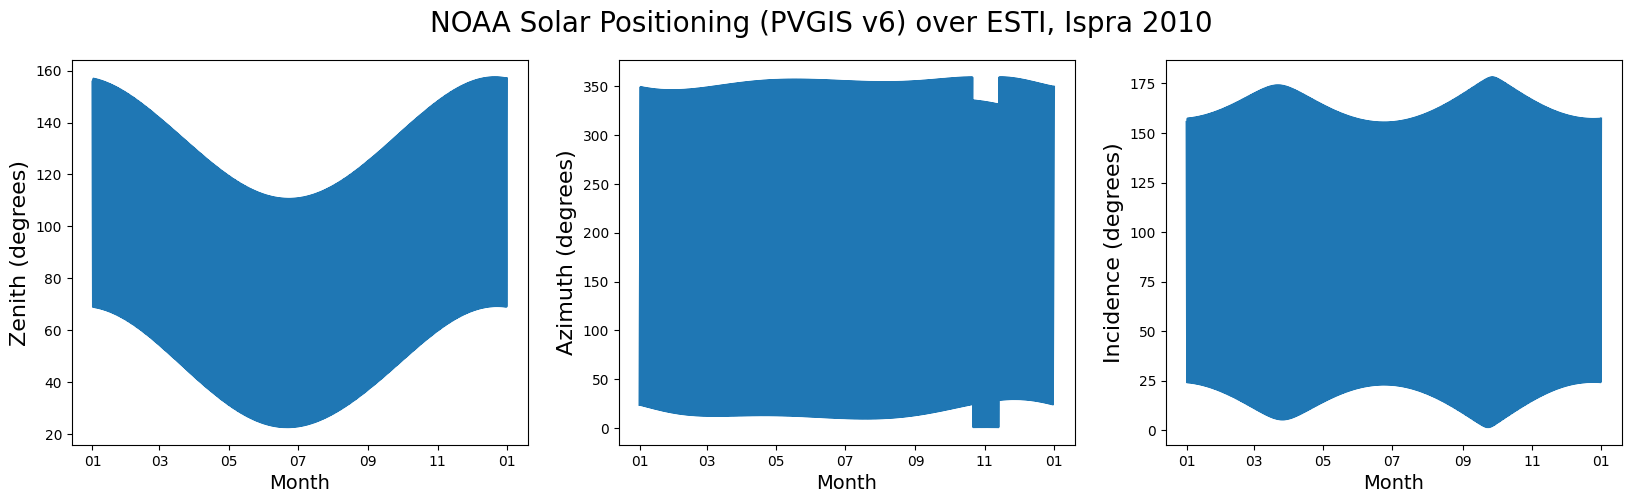

In [13]:
# Plots for solar zenith and solar azimuth angles
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(f'NOAA Solar Positioning (PVGIS v6) over ESTI, Ispra {timestamps[0].year}', fontsize=20)
ylabel_fontsize = 16
xlabel_fontsize = 14

# plot for solar zenith angle
ax1.plot(data.loc['2010']['Solar Zenith'])
ax1.set_ylabel('Zenith (degrees)', fontsize=ylabel_fontsize)
ax1.set_xlabel('Month', fontsize=xlabel_fontsize)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# plot for solar azimuth 
ax2.plot(data.loc['2010']['Solar Azimuth'])
ax2.set_ylabel('Azimuth (degrees)', fontsize=ylabel_fontsize)
ax2.set_xlabel('Month', fontsize=xlabel_fontsize)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# plot for solar incidence 
ax3.plot(data.loc['2010']['Solar Incidence'])
ax3.set_ylabel('Incidence (degrees)', fontsize=ylabel_fontsize)
ax3.set_xlabel('Month', fontsize=xlabel_fontsize)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

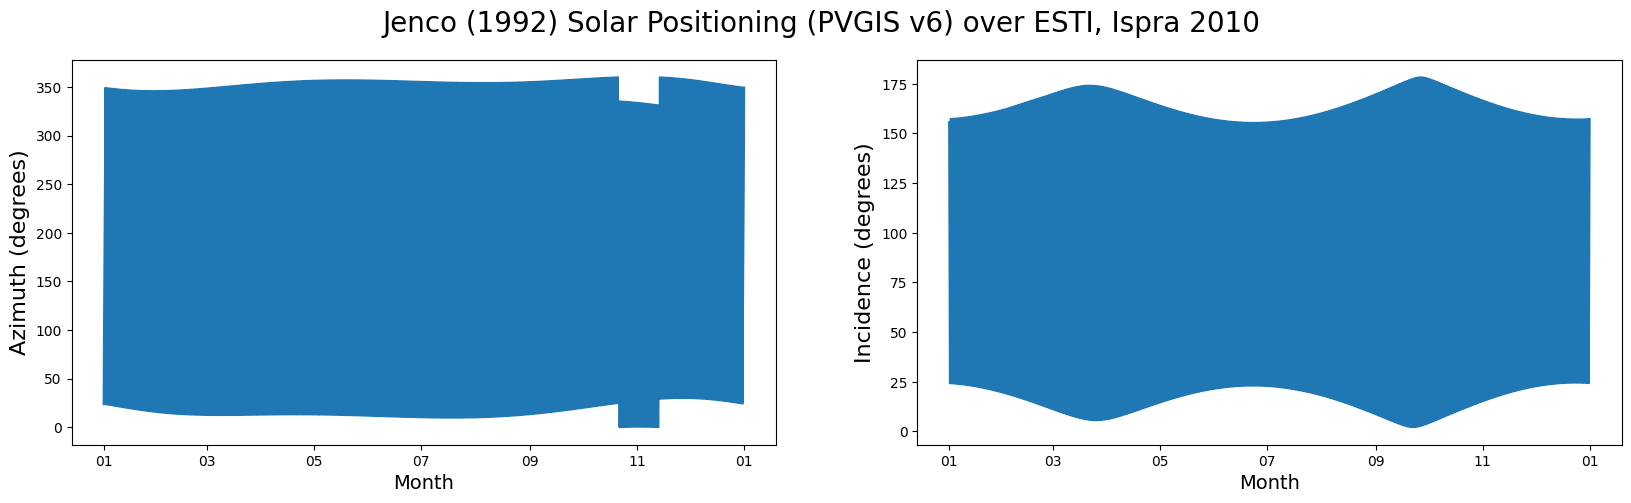

In [14]:
# Plots for solar zenith and solar azimuth angles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Jenco (1992) Solar Positioning (PVGIS v6) over ESTI, Ispra {timestamps[0].year}', fontsize=20)
ylabel_fontsize = 16
xlabel_fontsize = 14

# plot for solar azimuth 
ax1.plot(data_jenco.loc['2010']['Solar Azimuth'])
ax1.set_ylabel('Azimuth (degrees)', fontsize=ylabel_fontsize)
ax1.set_xlabel('Month', fontsize=xlabel_fontsize)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# plot for solar incidence 
ax2.plot(data_jenco.loc['2010']['Solar Incidence'])
ax2.set_ylabel('Incidence (degrees)', fontsize=ylabel_fontsize)
ax2.set_xlabel('Month', fontsize=xlabel_fontsize)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

We repeat the same plot however for 22 June 2010.

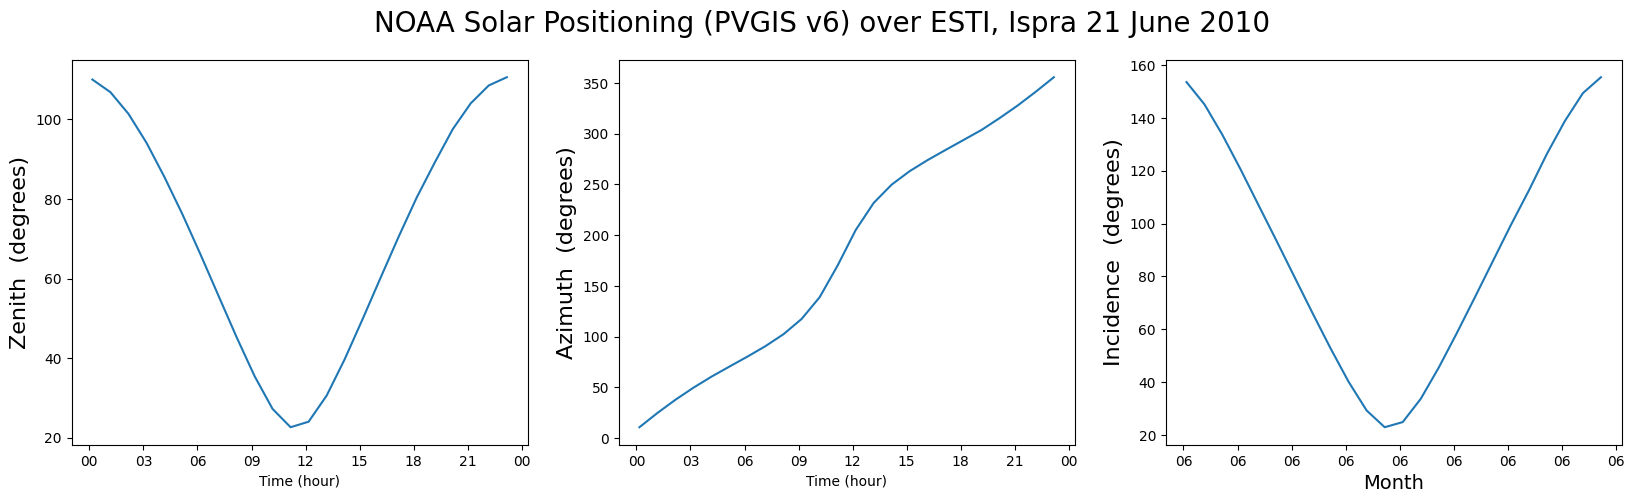

In [15]:
# Plots for solar zenith and solar azimuth angles
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(f'NOAA Solar Positioning (PVGIS v6) over ESTI, Ispra 21 June 2010', fontsize=20)

ylabel_fontsize = 16
xlabel_fontsize = 14
# plot for solar zenith angle
ax1.plot(data.loc['2010-06-21']['Solar Zenith'])
ax1.set_ylabel('Zenith  (degrees)', fontsize=ylabel_fontsize)
ax1.set_xlabel('Time (hour)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# plot for solar azimuth 
ax2.plot(data.loc['2010-06-21']['Solar Azimuth'])
ax2.set_ylabel('Azimuth  (degrees)', fontsize=ylabel_fontsize)
ax2.set_xlabel('Time (hour)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# plot for solar incidence 
ax3.plot(data.loc['2010-06-21']['Solar Incidence'])
ax3.set_ylabel('Incidence  (degrees)', fontsize=ylabel_fontsize)
ax3.set_xlabel('Month', fontsize=xlabel_fontsize)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

One more thing before engaging in to comparisons : we need to transform the timestamps of the PVGIS v5.2 data frame to be a Pandas DatetimeIndex, as the timestamps we use for the rest of the data.

In [16]:
from pandas import to_datetime
pvgis_52_orientation_180_tilt_45_2010.index = to_datetime(pvgis_52_orientation_180_tilt_45_2010['Timestamp'])
pvgis_52 = pvgis_52_orientation_180_tilt_45_2010.tz_localize(timezone)

## Comparison of algorithms

Bellow we calculate the differences in solar **zenith** and **azimuth** between PVGIS' implementation of NOAA solar geometry equations against NREL's SPA, PyEphem and Ephemeris, all implemented in `pvlib`.

We can visualize the differences in the estimations of the **solar zenith angle**:

### Solar zenith

#### NOAA vs others

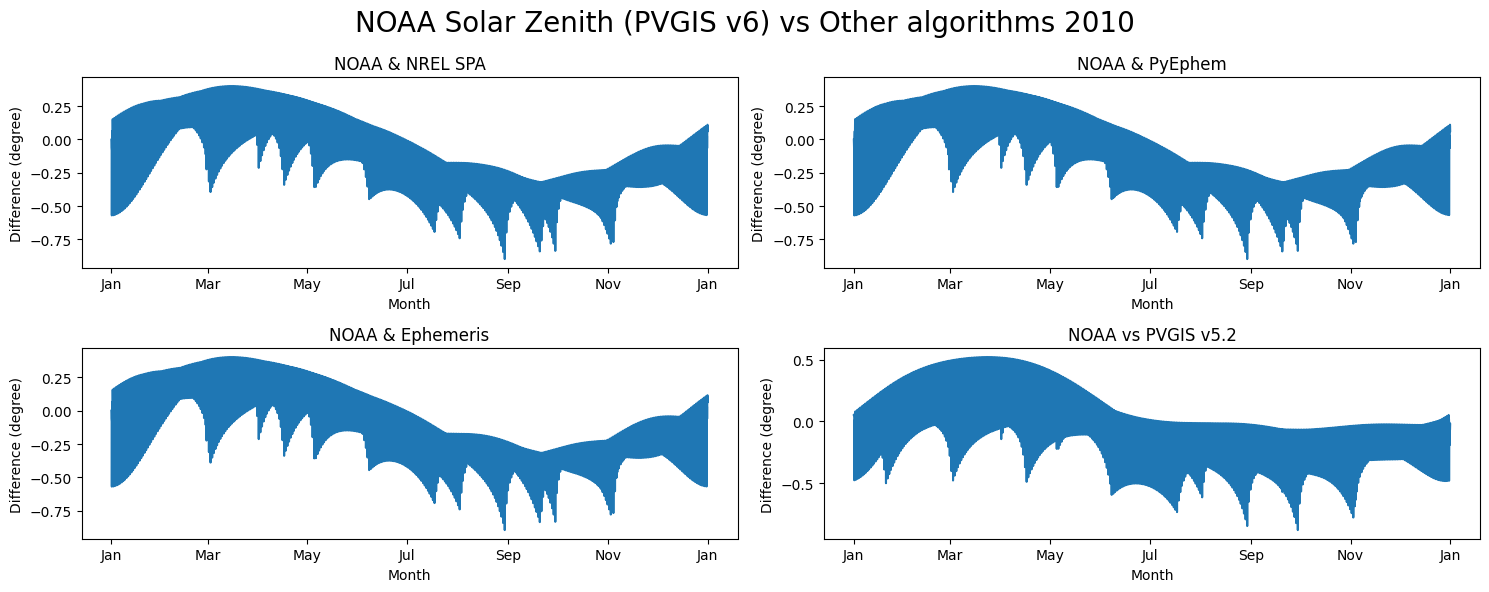

In [17]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.suptitle(f'NOAA Solar Zenith (PVGIS v6) vs Other algorithms {timestamps[0].year}', fontsize=20)
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

# Plot
axs[0].plot(data['Solar Zenith']-solpos_nrel['zenith'])
axs[1].plot(data['Solar Zenith']-solpos_pyephem['zenith'])
axs[2].plot(data['Solar Zenith']-solpos_ephemeris['zenith'])
axs[3].plot(data['Solar Zenith']-(90 - pvgis_52['Solar Altitude']))

# Add characteristics to each subplot in a loop
plots = ["NOAA & NREL SPA", "NOAA & PyEphem", "NOAA & Ephemeris", "NOAA vs PVGIS v5.2"]
for i in range(4):
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Difference (degree)')
    axs[i].set_title(plots[i])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

#### NREL SPA vs others

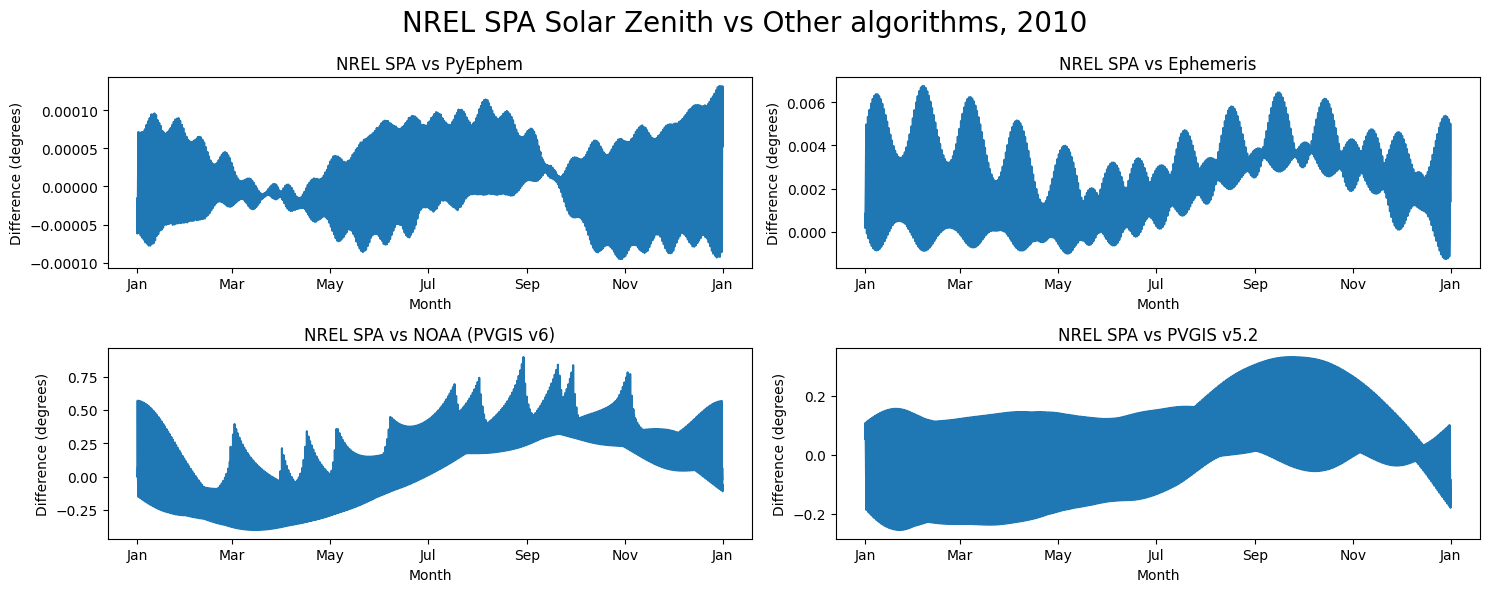

In [18]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.suptitle(f'NREL SPA Solar Zenith vs Other algorithms, {timestamps[0].year}', fontsize=20)
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

# Plot
axs[0].plot(solpos_nrel['zenith'] - solpos_pyephem['zenith'])
axs[1].plot(solpos_nrel['zenith'] - solpos_ephemeris['zenith'])
axs[2].plot(solpos_nrel['zenith'] - data['Solar Zenith'])
axs[3].plot(solpos_nrel['zenith'] - (90 - pvgis_52['Solar Altitude']))

# Add characteristics to each subplot in a loop
plots = ["NREL SPA vs PyEphem", "NREL SPA vs Ephemeris", "NREL SPA vs NOAA (PVGIS v6)", "NREL SPA vs PVGIS v5.2"]
for i in range(4):
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Difference (degrees)')
    axs[i].set_title(plots[i])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

#### PVGIS v5.2 vs others

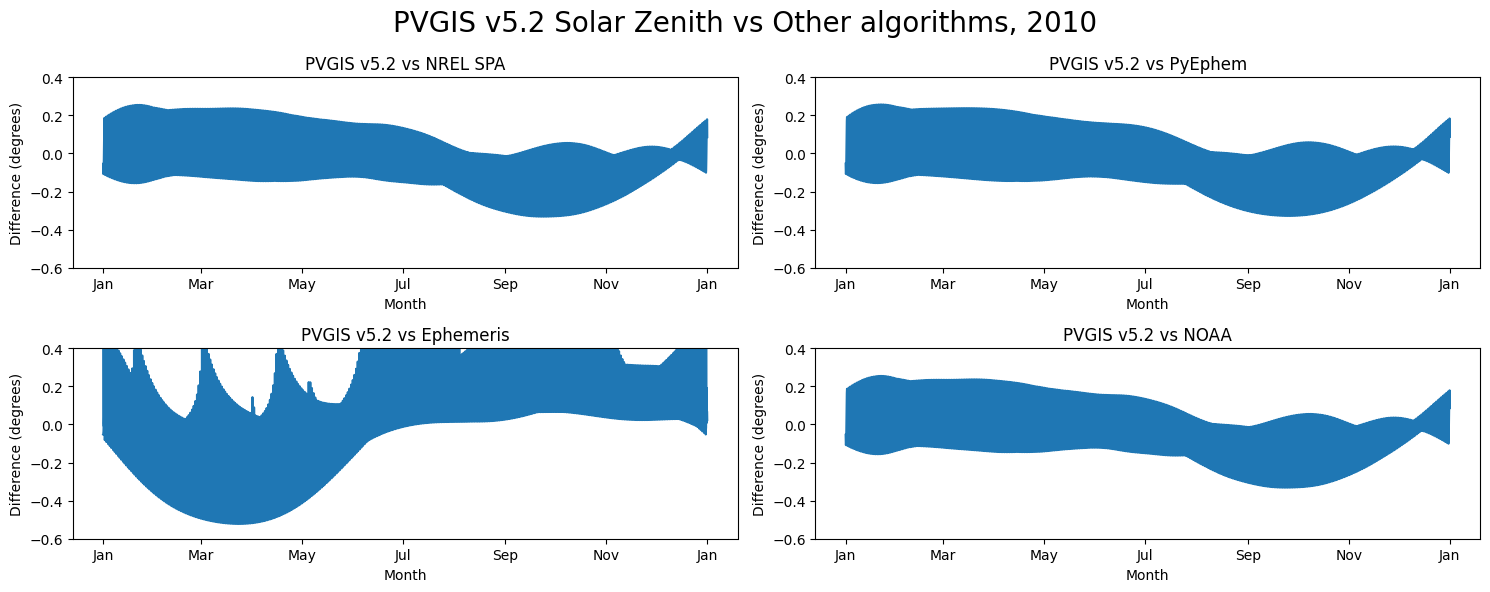

In [19]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.suptitle(f'PVGIS v5.2 Solar Zenith vs Other algorithms, {timestamps[0].year}', fontsize=20)
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

# Plot
axs[3].plot((90 - pvgis_52['Solar Altitude']) - solpos_nrel['zenith'])
axs[0].plot((90 - pvgis_52['Solar Altitude']) - solpos_pyephem['zenith'])
axs[1].plot((90 - pvgis_52['Solar Altitude']) - solpos_ephemeris['zenith'])
axs[2].plot((90 - pvgis_52['Solar Altitude']) - data['Solar Zenith'])

# Add characteristics to each subplot in a loop
plots = ["PVGIS v5.2 vs NREL SPA", "PVGIS v5.2 vs PyEphem", "PVGIS v5.2 vs Ephemeris", "PVGIS v5.2 vs NOAA"]
ymin = -0.6
ymax = .4
for idx in range(4):
    axs[idx].set_xlabel('Month')
    axs[idx].set_ylabel('Difference (degrees)')
    axs[idx].set_title(plots[idx])
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axs[idx].set_ylim([ymin, ymax])

plt.tight_layout()
plt.show()

### Solar azimuth

Then we can visualize the differences in the estimations of the **solar azimuth angle** as well:

#### NOAA vs others

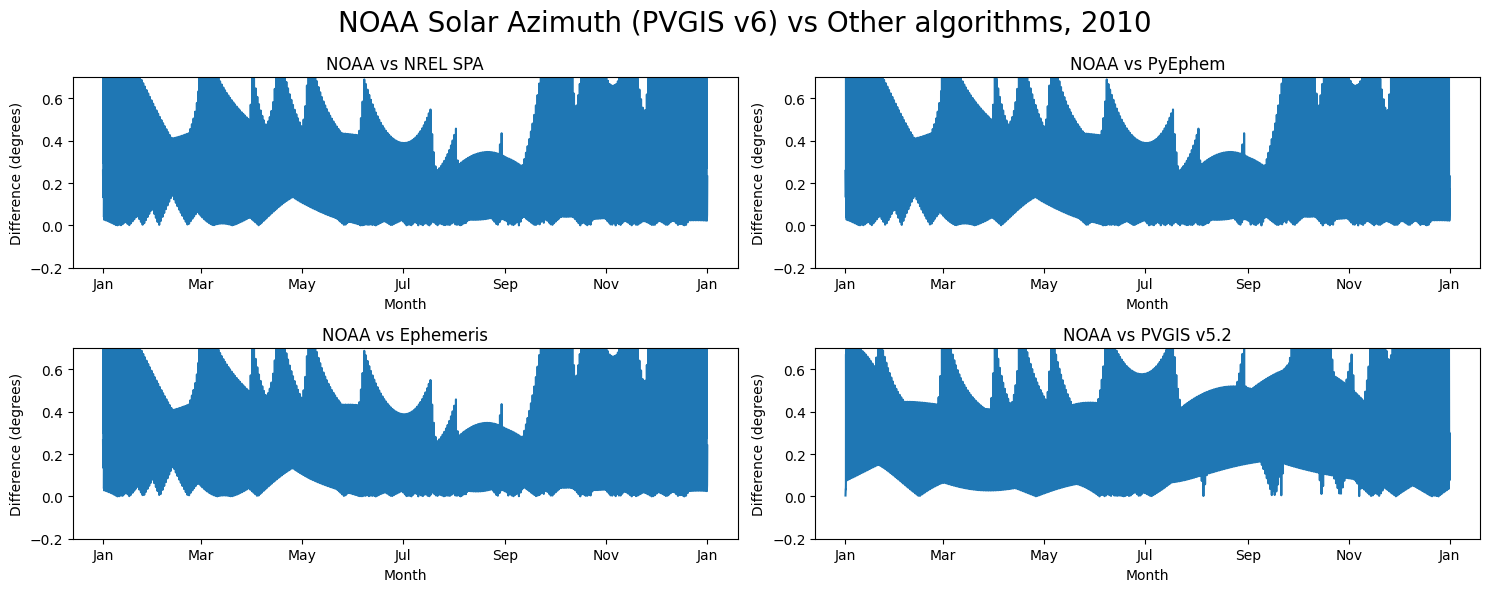

In [20]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.suptitle(f'NOAA Solar Azimuth (PVGIS v6) vs Other algorithms, {timestamps[0].year}', fontsize=20)
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

pvgis6_minus_nrel_spa = abs(data['Solar Azimuth'] % 360 - solpos_nrel['azimuth'] % 360)
pvgis6_minus_nrel_spa[pvgis6_minus_nrel_spa > 180] = 360 - pvgis6_minus_nrel_spa

pvgis6_minus_pyephem = abs(data['Solar Azimuth'] % 360 - solpos_pyephem['azimuth'] % 360)
pvgis6_minus_pyephem[pvgis6_minus_pyephem > 180] = 360 - pvgis6_minus_pyephem

pvgis6_minus_ephemeris = abs(data['Solar Azimuth'] % 360 - solpos_ephemeris['azimuth'] % 360)
pvgis6_minus_ephemeris[pvgis6_minus_ephemeris > 180] = 360 - pvgis6_minus_ephemeris

pvgis6_minus_pvgis_52 = abs(data['Solar Azimuth'] % 360 - pvgis_52['Solar Azimuth'] % 360)
pvgis6_minus_pvgis_52[pvgis6_minus_pvgis_52 > 180] = 360 - pvgis6_minus_pvgis_52

# print(pvgis6_minus_nrel_spa_x)
axs[0].plot(pvgis6_minus_nrel_spa)
axs[1].plot(pvgis6_minus_pyephem)
axs[2].plot(pvgis6_minus_ephemeris)
axs[3].plot(pvgis6_minus_pvgis_52)

# axs[0].get_shared_y_axes().join(axs[0], axs[1], axs[2])

# Add characteristics to each subplot in a loop
plot_titles = ["NOAA vs NREL SPA", "NOAA vs PyEphem", "NOAA vs Ephemeris", "NOAA vs PVGIS v5.2"]

ymin = -.2
ymax = .7
for idx in range(4):
    axs[idx].set_xlabel('Month')
    axs[idx].set_ylabel('Difference (degrees)')
    axs[idx].set_title(plot_titles[idx])
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axs[idx].set_ylim([ymin, ymax])

plt.tight_layout()
plt.show()

#### NREL SPA vs others

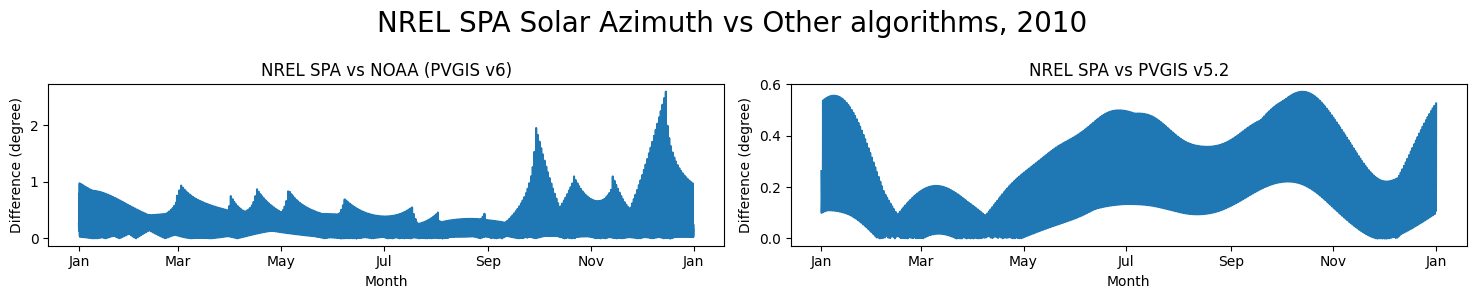

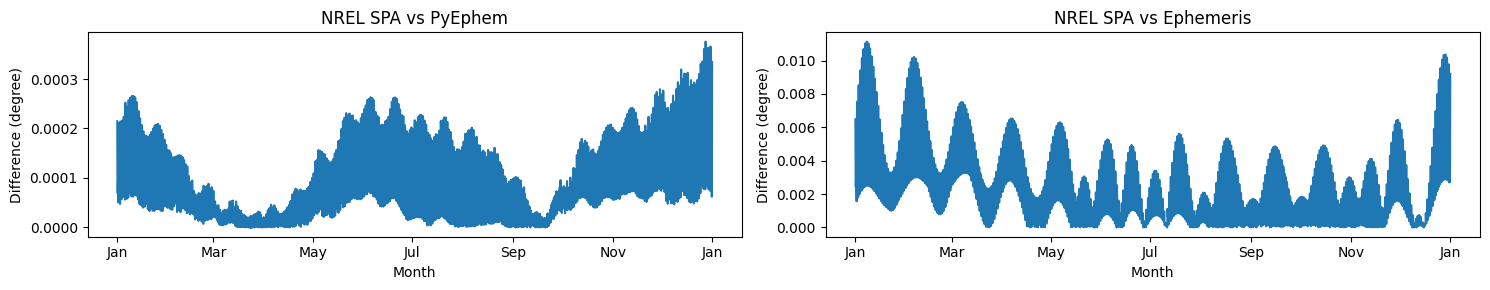

In [21]:
fig, axs = plt.subplots(1,2, figsize=(15, 3), facecolor='w', edgecolor='k')
fig.suptitle(f'NREL SPA Solar Azimuth vs Other algorithms, {timestamps[0].year}', fontsize=20)
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
# axs = axs.ravel()

nrel_spa_minus_pvgis6 = abs(solpos_nrel['azimuth'] % 360 - data['Solar Azimuth'] % 360)
nrel_spa_minus_pvgis6[nrel_spa_minus_pvgis6 > 180] = 360 - nrel_spa_minus_pvgis6

nrel_spa_minus_pvgis_52 = abs(solpos_nrel['azimuth'] % 360 - pvgis_52['Solar Azimuth'] % 360)
nrel_spa_minus_pvgis_52[nrel_spa_minus_pvgis_52 > 180] = 360 - nrel_spa_minus_pvgis_52

# print(nrel_spa_minus_nrel_spa_x)
axs[0].plot(nrel_spa_minus_pvgis6)
axs[1].plot(nrel_spa_minus_pvgis_52)


# axs[1].plot(nrel_spa_minus_pyephem)
# axs[2].plot(nrel_spa_minus_ephemeris)

# axs[0].get_shared_y_axes().join(axs[0], axs[1], axs[2])

# Add characteristics to each subplot in a loop
plot_titles = ["NREL SPA vs NOAA (PVGIS v6)", "NREL SPA vs PVGIS v5.2"]

ymin = -.2
ymax = .6
for idx in range(2):
    axs[idx].set_xlabel('Month')
    axs[idx].set_ylabel('Difference (degree)')
    axs[idx].set_title(plot_titles[idx])
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    # axs[idx].set_ylim([ymin, ymax])
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(15, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

nrel_spa_minus_pyephem = abs(solpos_nrel['azimuth'] % 360 - solpos_pyephem['azimuth'] % 360)
nrel_spa_minus_pyephem[nrel_spa_minus_pyephem > 180] = 360 - nrel_spa_minus_pyephem

nrel_spa_minus_ephemeris = abs(solpos_nrel['azimuth'] % 360 - solpos_ephemeris['azimuth'] % 360)
nrel_spa_minus_ephemeris[nrel_spa_minus_ephemeris > 180] = 360 - nrel_spa_minus_ephemeris

axs[0].plot(nrel_spa_minus_pyephem)
axs[1].plot(nrel_spa_minus_ephemeris)


# Add characteristics to each subplot in a loop
plot_titles = ["NREL SPA vs PyEphem", "NREL SPA vs Ephemeris"]
for idx in range(2):
    axs[idx].set_xlabel('Month')
    axs[idx].set_ylabel('Difference (degree)')
    axs[idx].set_title(plot_titles[idx])
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()


#### PVGIS v5.2 vs others

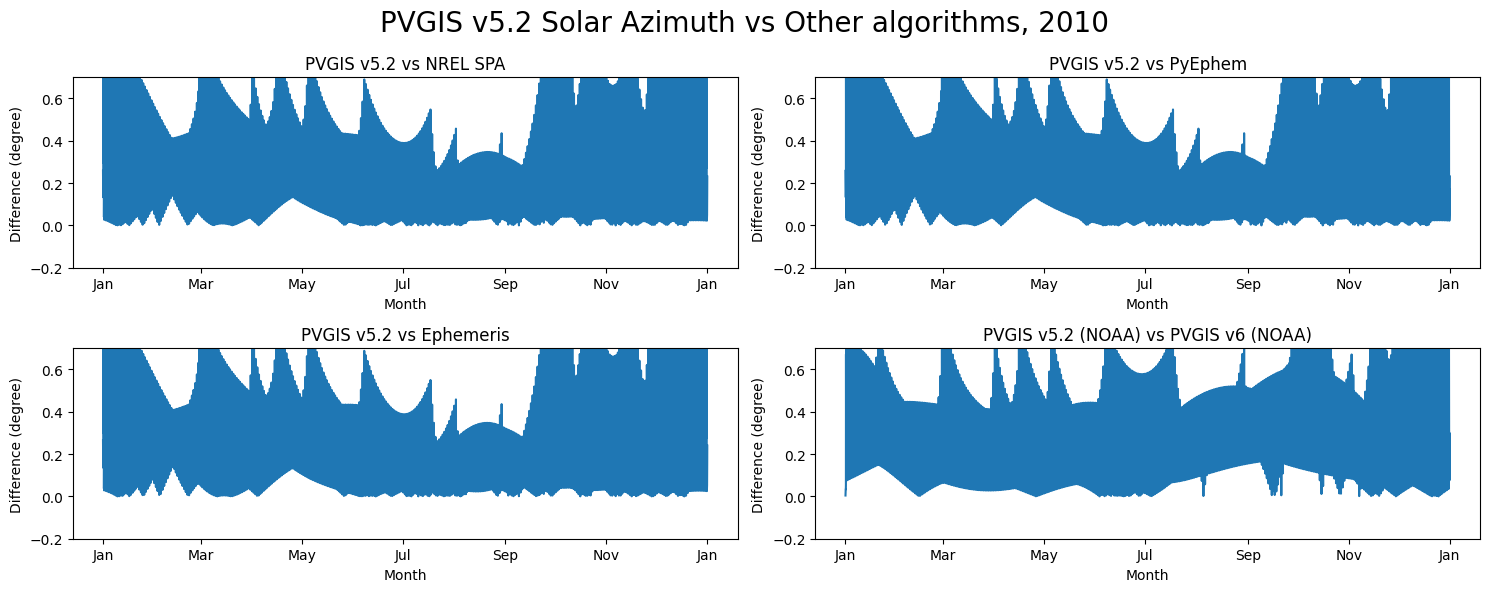

In [22]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.suptitle(f'PVGIS v5.2 Solar Azimuth vs Other algorithms, {timestamps[0].year}', fontsize=20)
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

pvgis_52_minus_nrel_spa = abs(data['Solar Azimuth'] % 360 - solpos_nrel['azimuth'] % 360)
pvgis_52_minus_nrel_spa[pvgis_52_minus_nrel_spa > 180] = 360 - pvgis_52_minus_nrel_spa

pvgis_52_minus_pyephem = abs(data['Solar Azimuth'] % 360 - solpos_pyephem['azimuth'] % 360)
pvgis_52_minus_pyephem[pvgis_52_minus_pyephem > 180] = 360 - pvgis_52_minus_pyephem

pvgis_52_minus_ephemeris = abs(data['Solar Azimuth'] % 360 - solpos_ephemeris['azimuth'] % 360)
pvgis_52_minus_ephemeris[pvgis_52_minus_ephemeris > 180] = 360 - pvgis_52_minus_ephemeris

pvgis_52_minus_pvgis6 = abs(data['Solar Azimuth'] % 360 - pvgis_52['Solar Azimuth'] % 360)
pvgis_52_minus_pvgis6[pvgis_52_minus_pvgis6 > 180] = 360 - pvgis_52_minus_pvgis6

# print(pvgis_52_minus_nrel_spa_x)
axs[0].plot(pvgis_52_minus_nrel_spa)
axs[1].plot(pvgis_52_minus_pyephem)
axs[2].plot(pvgis_52_minus_ephemeris)
axs[3].plot(pvgis_52_minus_pvgis6)

# axs[0].get_shared_y_axes().join(axs[0], axs[1], axs[2])

# Add characteristics to each subplot in a loop
plot_titles = ["PVGIS v5.2 vs NREL SPA", "PVGIS v5.2 vs PyEphem", "PVGIS v5.2 vs Ephemeris", "PVGIS v5.2 (NOAA) vs PVGIS v6 (NOAA)"]

ymin = -.2
ymax = .7
for idx in range(4):
    axs[idx].set_xlabel('Month')
    axs[idx].set_ylabel('Difference (degree)')
    axs[idx].set_title(plot_titles[idx])
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axs[idx].set_ylim([ymin, ymax])

plt.tight_layout()
plt.show()

Finally we compute the absolute differences between the methods

In [23]:
# compute the absolute difference in Solar Zenith Angle between SPA methods
pvis_nrel_sza = np.abs(data['Solar Zenith']-solpos_nrel['zenith']).max()
pvis_ephemeris_sza = np.abs(data['Solar Zenith']-solpos_ephemeris['zenith']).max()
pvis_pyephem_sza = np.abs(data['Solar Zenith']-solpos_pyephem['zenith']).max()

# list of variables 
methods_sza = [pvis_nrel_sza, pvis_ephemeris_sza, pvis_pyephem_sza] # Solar Zenith Angle

# compute the absolute difference in Solar Zenith Angle between SPA methods
pvis_nrel_azi = np.abs(data['Solar Azimuth']%360 - solpos_nrel['azimuth']%360)
pvis_nrel_azi[pvis_nrel_azi > 180] = 360 - pvis_nrel_azi
pvis_nrel_azi= pvis_nrel_azi.max()

pvis_ephemeris_azi = np.abs(data['Solar Azimuth']%360-solpos_ephemeris['azimuth']%360)
pvis_ephemeris_azi[pvis_ephemeris_azi > 180] = 360 - pvis_ephemeris_azi
pvis_ephemeris_azi= pvis_ephemeris_azi.max()

pvis_pyephem_azi = np.abs(data['Solar Azimuth']%360-solpos_pyephem['azimuth']%360)
pvis_pyephem_azi[pvis_pyephem_azi > 180] = 360 - pvis_pyephem_azi
pvis_pyephem_azi= pvis_pyephem_azi.max()

# list of variables 
methods_azi = [pvis_nrel_azi, pvis_ephemeris_azi, pvis_pyephem_azi] # Solar Azimuth Angle

spa_names = ["PVIS & NREL SPA ('nrel_numpy')", "PVIS & PyEphem", "PVIS & Ephemeris"]

print("Absolute differences between solar position algorithms:\n" + "-"*55)
print("Solar Zenith Angle [Degrees]")
for i in range(len(spa_names)):
    print("-", spa_names[i], ": {:.5f}".format(methods_sza[i]))

print("\nSolar Azimuth Angle [Degrees]")
for i in range(len(spa_names)):
    print("-", spa_names[i], ": {:.5f}".format(methods_azi[i]))

Absolute differences between solar position algorithms:
-------------------------------------------------------
Solar Zenith Angle [Degrees]
- PVIS & NREL SPA ('nrel_numpy') : 0.89787
- PVIS & PyEphem : 0.89425
- PVIS & Ephemeris : 0.89787

Solar Azimuth Angle [Degrees]
- PVIS & NREL SPA ('nrel_numpy') : 2.59699
- PVIS & PyEphem : 2.59696
- PVIS & Ephemeris : 2.59712


### Solar incidence

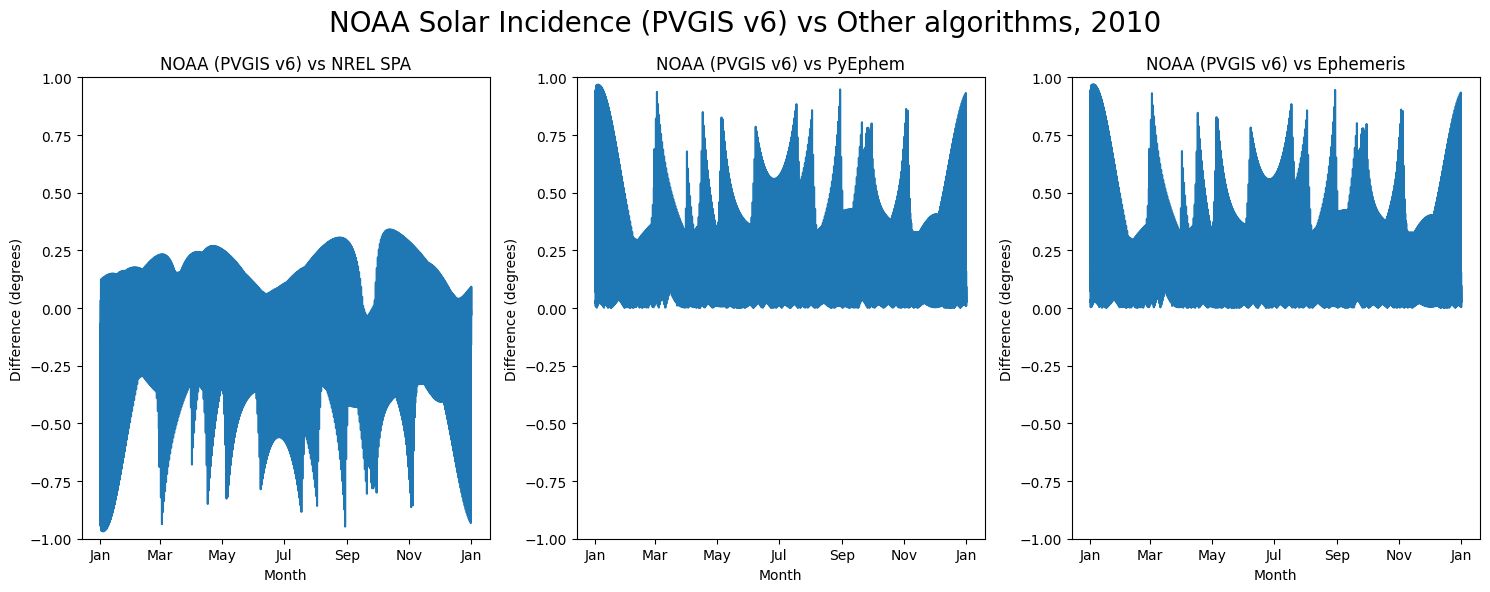

In [24]:
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.suptitle(f'NOAA Solar Incidence (PVGIS v6) vs Other algorithms, {timestamps[0].year}', fontsize=20)
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

pvgis6_minus_nrel_spa_incidence = data['Solar Incidence'] % 360 - solar_incidence_series_pvlib_nrel % 360
pvgis6_minus_nrel_spa[pvgis6_minus_nrel_spa > 180] = 360 - pvgis6_minus_nrel_spa

pvgis6_minus_pyephem = abs(data['Solar Incidence'] % 360 - solar_incidence_series_pvlib_pyephem % 360)
pvgis6_minus_pyephem[pvgis6_minus_pyephem > 180] = 360 - pvgis6_minus_pyephem

pvgis6_minus_ephemeris = abs(data['Solar Incidence'] % 360 - solar_incidence_series_pvlib_ephemeris % 360)
pvgis6_minus_ephemeris[pvgis6_minus_ephemeris > 180] = 360 - pvgis6_minus_ephemeris

#pvgis6_minus_pvgis_52_incidence = data['Solar Incidence'] - (90 - pvgis_52['Solar Incidence'])
# pvgis6_minus_pvgis_52[pvgis6_minus_pvgis_52 > 180] = 360 - pvgis6_minus_pvgis_52

# print(pvgis6_minus_nrel_spa_x)
axs[0].plot(pvgis6_minus_nrel_spa_incidence)
axs[1].plot(pvgis6_minus_pyephem)
axs[2].plot(pvgis6_minus_ephemeris)
#axs[3].plot(pvgis6_minus_pvgis_52_incidence)

# axs[0].get_shared_y_axes().join(axs[0], axs[1], axs[2])

# Add characteristics to each subplot in a loop
plot_titles = ["NOAA (PVGIS v6) vs NREL SPA", "NOAA (PVGIS v6) vs PyEphem", "NOAA (PVGIS v6) vs Ephemeris"]#, "NOAA (PVGIS v6) vs PVGIS v5.2"]

ymin = -1
ymax = 1
for idx in range(3):
    axs[idx].set_xlabel('Month')
    axs[idx].set_ylabel('Difference (degrees)')
    axs[idx].set_title(plot_titles[idx])
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axs[idx].set_ylim([ymin, ymax])

plt.tight_layout()
plt.show()

## Solar analemma

The solar analemma, an application of solar positioning, is a diagram showing the position of the sun in the sky as seen from a fixed location on Earth at the same mean solar time. Here we use Python and the function `model_solar_position_overview_series()` from PVGIS' core API v6 to implement the analemma as follows:

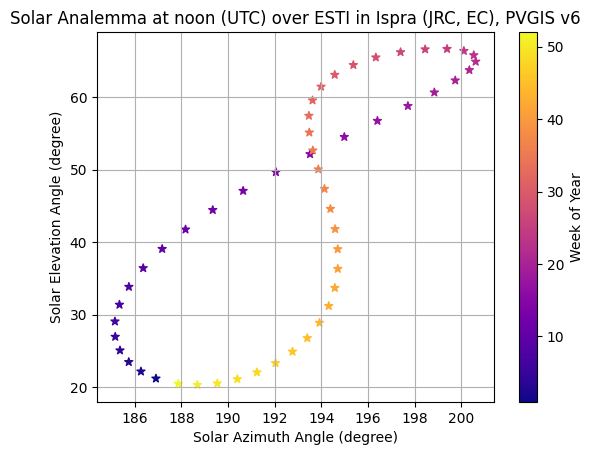

In [25]:
# Get specific dates in this case all 2018
timestamps = pd.date_range('2020-01-01 12:00:00', '2021-01-01 12:00:00', freq='W', tz=timezone)

position = model_solar_position_overview_series(
    longitude=longitude,
    latitude=latitude,
    timestamps=timestamps,
    timezone=timezone,
    surface_orientation=surface_orientation,
    surface_tilt=surface_tilt,
    solar_position_model=SolarPositionModel.noaa,
    apply_atmospheric_refraction=False,
    solar_incidence_model=SolarIncidenceModel.iqbal,
    zero_negative_solar_incidence_angles=False,
)

data = pd.DataFrame({'Datetime': timestamps, 
                   'Solar Declination': position[0].degrees,
                   'Solar Hour Angle': position[1].degrees,
                   'Solar Zenith': position[2].degrees,
                   'Solar Altitude': position[3].degrees,
                   'Solar Azimuth': position[4].degrees,
                   'Solar Incidence':position[7].degrees,
                    })

# Plotting the Analemma
plt.scatter(data['Solar Azimuth'], data['Solar Altitude'], marker="*", c=timestamps.isocalendar().week, cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('Week of Year')
plt.xlabel('Solar Azimuth Angle (degree)')
plt.ylabel('Solar Elevation Angle (degree)')
plt.title('Solar Analemma at noon (UTC) over ESTI in Ispra (JRC, EC), PVGIS v6')
plt.grid()
plt.show()

## References

- [Solar Position](https://assessingsolar.org/notebooks/solar_position.html) article by The Assessing Solar Community (2022)